# Summary

NO is used here as a corrector, i.e., it takes the approximate solution and produces a better approximation from it.

Observations:

1. Initialization is important. Surprisingly, standard training fails to provide solution better that linear regression.
2. When initialization is reasonable, one can skip one iteration of SDC, i.e., we obtain higher order solver (the bounds probably are $5\leq \text{ord}\leq 6$). In the current setting we saved $\simeq 350$ function evaluations in comparison with SDC.
3. The strategy is not working when we repeat it using the input of the first neural operator as features to the second neural operator. Probably, need to add some mechanism that correct errors obtained by NO (another iteration of SDC or Picard i).

In [1]:
! pip -q install --no-dependencies equinox jaxtyping

In [2]:
! pip -q install optax

In [3]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
Already up to date.


In [4]:
import jax.numpy as jnp
from jax import config, random, jit, vmap, grad
from jax.lax import dot_general

import equinox as eqx
import optax

from architectures import ChebNO
from datasets import generate_dataset, metrics
from misc import equations

from integrators import RK4, Explicit_Euler, Implicit_Euler
from sdc_integrators import RK4 as RK4_c, Explicit_Euler as Explicit_Euler_c, Implicit_Euler as Implicit_Euler_c

config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [5]:
def batch_generator(train_data, key, chunk_size):
    train_features, train_targets = train_data
    n = random.permutation(key, jnp.arange(train_features.shape[0], dtype=int))
    train_features, train_targets = train_features[n], train_targets[n]
    chunks = [*range(0, train_features.shape[0] + 1, chunk_size)]
    if chunks[-1] < train_features.shape[0]:
        chunks.append(train_features.shape[0])
    for i, j in zip(chunks[:-1], chunks[1:]):
        yield train_features[i:j], train_targets[i:j]

Solve ODE

In [6]:
ODE_data = equations.get_ODE("Lorenz")
integrator = "RK4"
P_u0 = lambda key: random.normal(key, (3,))
key = random.PRNGKey(13)
N_points = 40
T_max = 1
N_intervals = 2
N_SDC = 20
N_samples = 1000

dataset, T = generate_dataset.concoct_regular_dataset(ODE_data, integrator, P_u0, T_max, N_points, N_intervals, N_SDC, N_samples, key)

Check residuals

In [7]:
# computing residual for the last SDC iteration
R = generate_dataset.get_residual(dataset, ODE_data, T_max, N_intervals)
print("shape of computed residual", R.shape)
print(jnp.mean(R))

shape of computed residual (1000, 2)
2.345958413065942e-13


Prepare features and targers.

In [8]:
features = dataset[:, :, :2, :, :]
targets = dataset[:, :, -1, :, :]

feature_train = features[:800, :, :, :, :].reshape(800*N_intervals, features.shape[2]*features.shape[3], -1)
targets_train = targets[:800, :, :, :].reshape(800*N_intervals, targets.shape[2], -1)

feature_test = features[800:, :, :, :, :].reshape(200*N_intervals, features.shape[2]*features.shape[3], -1)
targets_test = targets[800:, :, :, :].reshape(200*N_intervals, targets.shape[2], -1)

In [9]:
feature_train.shape, targets_train.shape

((1600, 6, 40), (1600, 3, 40))

In [10]:
feature_test.shape, targets_test.shape

((400, 6, 40), (400, 3, 40))

# NO with skip connection, random initialization

Implement neural network.

In [11]:
class ResChebNO(ChebNO.ChebNO):
    encoder: eqx.Module
    decoder: eqx.Module
    spectral_processor: list
    processor: list
    N_modes: int
    mixing: jnp.array
    scale: jnp.array

    def __init__(self, N_features, N_layers, spectral_kernel_size, N_conv, N_modes, key, spatial_kernel_size=1, h=1, mixing_init=None):
        super().__init__(N_features, N_layers, spectral_kernel_size, N_conv, N_modes, key, spatial_kernel_size=spatial_kernel_size)
        keys = random.split(key, 2)
        if mixing_init is None:
            self.mixing = random.normal(keys[1], (N_features[2], N_features[0]))
        else:
            self.mixing = mixing_init
        self.scale = h * random.normal(keys[1], (N_features[2], 1))

    def __call__(self, x):
        z = super().__call__(x)
        return self.scale * z + dot_general(self.mixing, x, (((1,), (0,)), ((), ())))

In [12]:
key = random.PRNGKey(23)

N_features = [feature_train.shape[1], 64, targets_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = 10
model2 = ResChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key, h=1e-3)

In [13]:
learning_rate = 1e-3
weight_decay = 1e-2
N_batch = 50
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature_train.shape[0] / N_batch) * N_epoch_decay, 0.5)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model2, eqx.is_array))

In [14]:
ChebNO.make_step(model2, feature_train[:N_batch], targets_train[:N_batch], optim, opt_state);

In [15]:
%timeit ChebNO.make_step(model2, feature_train[:N_batch], targets_train[:N_batch], optim, opt_state);

15.2 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
15 * 1e-3 * (feature_train.shape[0] / N_batch) * N_epoch / 60

4.0

In [17]:
%timeit ChebNO.compute_loss(model2, feature_train, targets_train);

182 ms ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature_train, targets_train], key, N_batch)
    for feature, target in ds:
        loss, model2, opt_state = ChebNO.make_step(model2, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model2, feature_train, targets_train).item())
    e_test.append(ChebNO.compute_loss(model2, feature_test, targets_test).item())

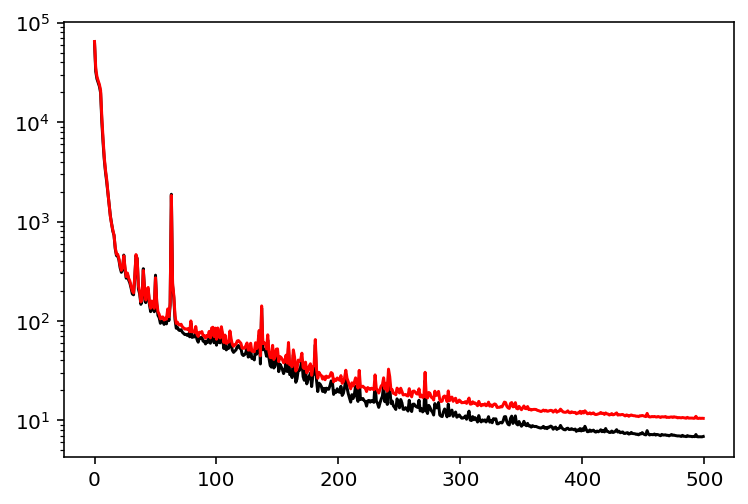

In [19]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

In [20]:
sample = 25
prediction = model2(feature_train[sample])

Errors_RK4 = [jnp.linalg.norm(feature_train[sample].reshape(2, 3, -1)[1, k, :] - targets_train[sample][k]) for k in range(3)]
Errors_NO = [jnp.linalg.norm(prediction[k, :] - targets_train[sample][k]) for k in range(3)]

print([e.item() for e in Errors_RK4])
print([e.item() for e in Errors_NO])

[0.0001940100963974609, 0.0002788058601150325, 0.0003893241841160863]
[0.3188452178073493, 0.4708142172330137, 0.3059624688360073]


In [21]:
def apply_model(features, t0, t1, model):
    return model(features)

def get_features(dataset_t, model_output, features_type, n):
    return dataset_t[:n, :, :].reshape(n*3, -1)

def apply_SDC(features, t0, t1, N_SDC):
    solver = RK4.integrator
    corrector = RK4_c.deferred_correction
    values = solver(features, ODE_data["F"], N_points, t0, t1)
    for i in range(N_SDC-2):
        values = corrector(values, ODE_data["F"], t0, t1)
    return values

def get_features_SDC(dataset_t, model_output, features_type):
    return dataset_t[-1, :, 0]

def get_features_RK4(dataset_t, model_output, features_type):
    return dataset_t[1, :, :]

def get_features_exact(dataset_t, model_output, features_type, k):
    return dataset_t[k, :, :]

In [22]:
apply_model_ = lambda a, b, c: apply_model(a, b, c, model2)
get_features_ = lambda a, b, c: get_features(a, b, c, 2)

train_errors_one_shot = metrics.relative_error(apply_model_, get_features_, dataset[:800], T)
mean_train_errors_one_shot = metrics.mean_relative_error(train_errors_one_shot)

test_errors_one_shot = metrics.relative_error(apply_model_, get_features_, dataset[800:], T)
mean_test_errors_one_shot = metrics.mean_relative_error(test_errors_one_shot)

train_errors_solver = []
test_errors_solver = []
for i in [1, 2, 3]:
    train_errors = metrics.relative_error(lambda x, a, b: x, lambda a, b, c: get_features_exact(a, b, c, i), dataset[:800], T)
    mean_train_errors = metrics.mean_relative_error(train_errors)
    train_errors_solver.append(mean_train_errors)

    test_errors = metrics.relative_error(lambda x, a, b: x, lambda a, b, c: get_features_exact(a, b, c, i), dataset[:800], T)
    mean_test_errors = metrics.mean_relative_error(test_errors)
    test_errors_solver.append(mean_test_errors)

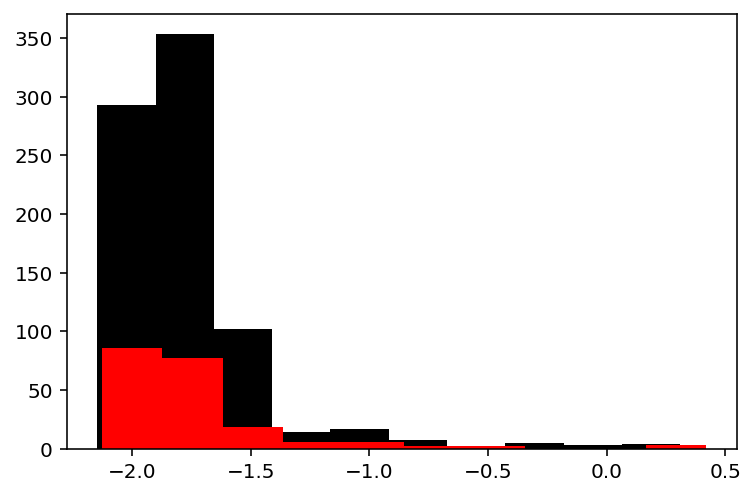

In [23]:
plt.hist(jnp.log10(mean_train_errors_one_shot), color="black")
plt.hist(jnp.log10(mean_test_errors_one_shot), color="red");

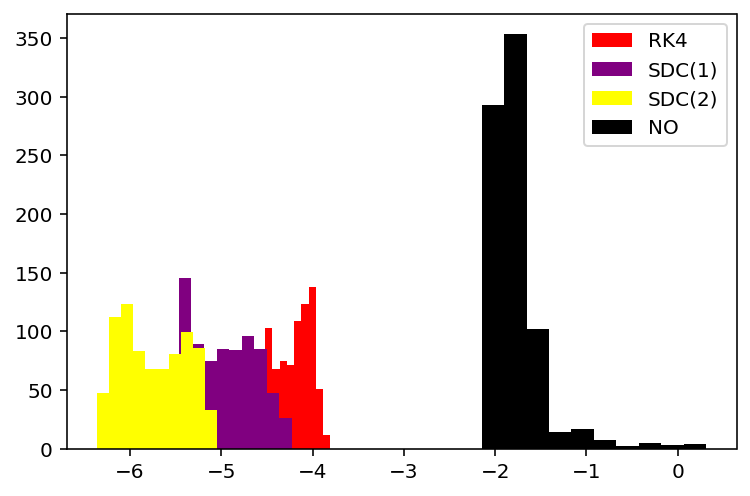

In [24]:
plt.hist(jnp.log10(train_errors_solver[0]), color="red", label="RK4")
plt.hist(jnp.log10(train_errors_solver[1]), color="purple", label="SDC(1)")
plt.hist(jnp.log10(train_errors_solver[2]), color="yellow", label="SDC(2)")
plt.hist(jnp.log10(mean_train_errors_one_shot), color="black", label="NO")
plt.legend();

In [25]:
print("log(mean train error)")
print("Neural Operator", jnp.log10(jnp.mean(mean_train_errors_one_shot)))
print("RK4", jnp.log10(jnp.mean(train_errors_solver[0])))
print("SDC(1)", jnp.log10(jnp.mean(train_errors_solver[1])))
print("SDC(2)", jnp.log10(jnp.mean(train_errors_solver[2])))

log(mean train error)
Neural Operator -1.4722436296902752
RK4 -4.171750346143119
SDC(1) -4.855239253002348
SDC(2) -5.600862526728036


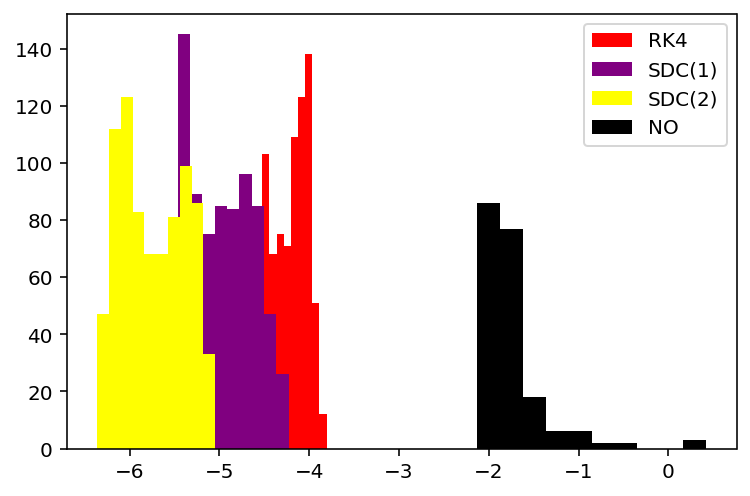

In [26]:
plt.hist(jnp.log10(test_errors_solver[0]), color="red", label="RK4")
plt.hist(jnp.log10(test_errors_solver[1]), color="purple", label="SDC(1)")
plt.hist(jnp.log10(test_errors_solver[2]), color="yellow", label="SDC(2)")
plt.hist(jnp.log10(mean_test_errors_one_shot), color="black", label="NO")
plt.legend();

In [27]:
print("log(mean test error)")
print("Neural Operator", jnp.log10(jnp.mean(mean_test_errors_one_shot)))
print("RK4", jnp.log10(jnp.mean(test_errors_solver[0])))
print("SDC(1)", jnp.log10(jnp.mean(test_errors_solver[1])))
print("SDC(2)", jnp.log10(jnp.mean(test_errors_solver[2])))

log(mean test error)
Neural Operator -1.2660187941810634
RK4 -4.171750346143119
SDC(1) -4.855239253002348
SDC(2) -5.600862526728036


The model is not training, need to fix initialization manually.

# NO with skip connection, reasonable initialization

In [28]:
good_mixing = jnp.kron(jnp.array([0, 1]), jnp.eye(3))

key = random.PRNGKey(23)

N_features = [feature_train.shape[1], 64, targets_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = 10
model2 = ResChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key, h=1e-3, mixing_init=good_mixing)

train_errors_one_shot = metrics.relative_error(apply_model_, get_features_, dataset[:800], T)
mean_train_errors_one_shot = metrics.mean_relative_error(train_errors_one_shot)

test_errors_one_shot = metrics.relative_error(apply_model_, get_features_, dataset[800:], T)
mean_test_errors_one_shot = metrics.mean_relative_error(test_errors_one_shot)

print(jnp.mean(mean_train_errors_one_shot), jnp.mean(mean_test_errors_one_shot))

6.76920334216072e-05 6.653182741013787e-05


In [29]:
learning_rate = 1e-5
weight_decay = 1e-2
N_batch = 50
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature_train.shape[0] / N_batch) * N_epoch_decay, 0.5)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model2, eqx.is_array))

In [30]:
ChebNO.make_step(model2, feature_train[:N_batch], targets_train[:N_batch], optim, opt_state);

In [31]:
%timeit ChebNO.make_step(model2, feature_train[:N_batch], targets_train[:N_batch], optim, opt_state);

14.6 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
15 * 1e-3 * (feature_train.shape[0] / N_batch) * N_epoch / 60

4.0

In [33]:
%timeit ChebNO.compute_loss(model2, feature_train, targets_train);

129 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature_train, targets_train], key, N_batch)
    for feature, target in ds:
        loss, model2, opt_state = ChebNO.make_step(model2, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model2, feature_train, targets_train).item())
    e_test.append(ChebNO.compute_loss(model2, feature_test, targets_test).item())

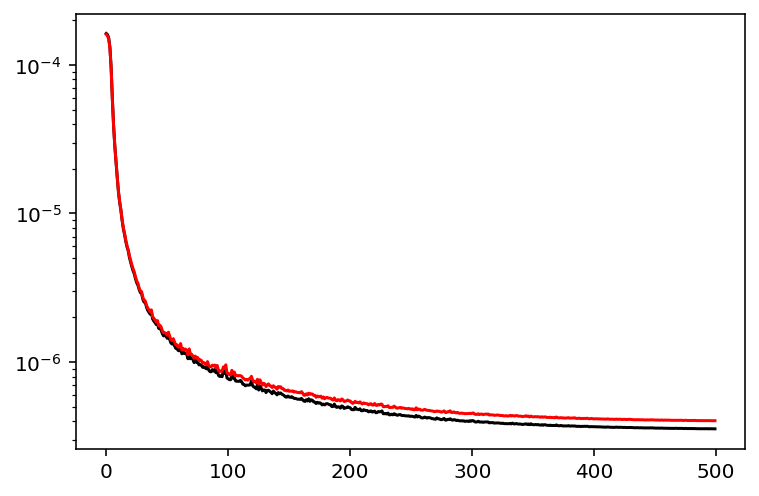

In [35]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

In [36]:
apply_model_ = lambda a, b, c: apply_model(a, b, c, model2)
get_features_ = lambda a, b, c: get_features(a, b, c, 2)

train_errors_one_shot = metrics.relative_error(apply_model_, get_features_, dataset[:800], T)
mean_train_errors_one_shot = metrics.mean_relative_error(train_errors_one_shot)

test_errors_one_shot = metrics.relative_error(apply_model_, get_features_, dataset[800:], T)
mean_test_errors_one_shot = metrics.mean_relative_error(test_errors_one_shot)

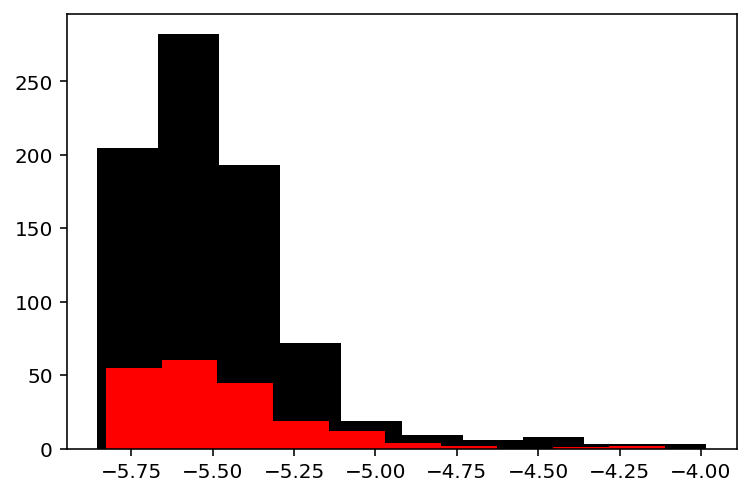

In [37]:
plt.hist(jnp.log10(mean_train_errors_one_shot), color="black")
plt.hist(jnp.log10(mean_test_errors_one_shot), color="red");

In [38]:
train_errors_solver = []
test_errors_solver = []
for i in [1, 2, 3]:
    train_errors = metrics.relative_error(lambda x, a, b: x, lambda a, b, c: get_features_exact(a, b, c, i), dataset[:800], T)
    mean_train_errors = metrics.mean_relative_error(train_errors)
    train_errors_solver.append(mean_train_errors)

    test_errors = metrics.relative_error(lambda x, a, b: x, lambda a, b, c: get_features_exact(a, b, c, i), dataset[:800], T)
    mean_test_errors = metrics.mean_relative_error(test_errors)
    test_errors_solver.append(mean_test_errors)

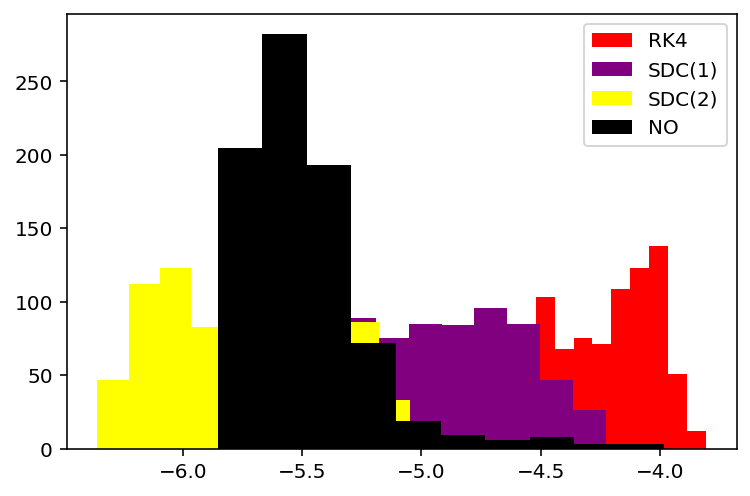

In [39]:
plt.hist(jnp.log10(train_errors_solver[0]), color="red", label="RK4")
plt.hist(jnp.log10(train_errors_solver[1]), color="purple", label="SDC(1)")
plt.hist(jnp.log10(train_errors_solver[2]), color="yellow", label="SDC(2)")
plt.hist(jnp.log10(mean_train_errors_one_shot), color="black", label="NO")
plt.legend();

In [40]:
print("log(mean train error)")
print("Neural Operator", jnp.log10(jnp.mean(mean_train_errors_one_shot)))
print("RK4", jnp.log10(jnp.mean(train_errors_solver[0])))
print("SDC(1)", jnp.log10(jnp.mean(train_errors_solver[1])))
print("SDC(2)", jnp.log10(jnp.mean(train_errors_solver[2])))

log(mean train error)
Neural Operator -5.3579422318801395
RK4 -4.171750346143119
SDC(1) -4.855239253002348
SDC(2) -5.600862526728036


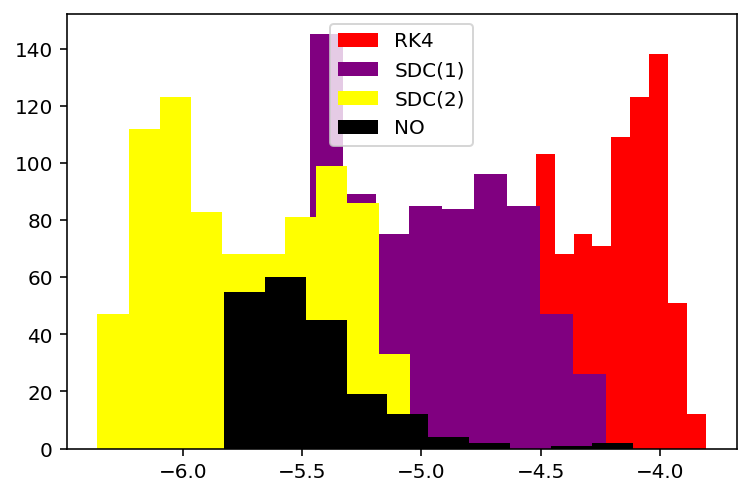

In [41]:
plt.hist(jnp.log10(test_errors_solver[0]), color="red", label="RK4")
plt.hist(jnp.log10(test_errors_solver[1]), color="purple", label="SDC(1)")
plt.hist(jnp.log10(test_errors_solver[2]), color="yellow", label="SDC(2)")
plt.hist(jnp.log10(mean_test_errors_one_shot), color="black", label="NO")
plt.legend();

In [42]:
print("log(mean test error)")
print("Neural Operator", jnp.log10(jnp.mean(mean_test_errors_one_shot)))
print("RK4", jnp.log10(jnp.mean(test_errors_solver[0])))
print("SDC(1)", jnp.log10(jnp.mean(test_errors_solver[1])))
print("SDC(2)", jnp.log10(jnp.mean(test_errors_solver[2])))

log(mean test error)
Neural Operator -5.334112734999745
RK4 -4.171750346143119
SDC(1) -4.855239253002348
SDC(2) -5.600862526728036


So managed to skip one stage of SDC. What does it mean in terms of function evaluation?

For RK4

+ Each sweep requires $4\times (N-1)$ function evaluations, where $N$ is a number of points in the domain.

+ The computation of residual requires $(N-1)$ function evaluations.

+ The solution of error equation requires $2\times 4 \times (N-1)$ function evaluations.

In total we have $9(N-1)$ sweeps for SDC step.

In our case it gives us

In [43]:
N = feature_train.shape[-1]
9*(N-1)

351

Since our operator is more accurate than a single SDC step, we safe this much function evaluation.

# Stacking two NOs

In [44]:
feature_train_ = jnp.concatenate([feature_train, vmap(model2)(feature_train)], axis=1)
feature_test_ = jnp.concatenate([feature_test, vmap(model2)(feature_test)], axis=1)

In [45]:
dataset.shape

(1000, 2, 20, 3, 40)

In [46]:
def get_errors(dataset, k):
    train_error = jnp.linalg.norm((dataset[:800, :, k, :, :] - dataset[:800, :, -1, :, :]).reshape(-1, dataset.shape[3], dataset.shape[4]), axis=2) / jnp.linalg.norm((dataset[:800, :, -1, :, :]).reshape(-1, dataset.shape[3], dataset.shape[4]), axis=2)
    test_error = jnp.linalg.norm((dataset[800:, :, k, :, :] - dataset[800:, :, -1, :, :]).reshape(-1, dataset.shape[3], dataset.shape[4]), axis=2) / jnp.linalg.norm((dataset[800:, :, -1, :, :]).reshape(-1, dataset.shape[3], dataset.shape[4]), axis=2)
    return train_error, test_error

In [47]:
good_mixing = jnp.kron(jnp.array([0, 0, 1]), jnp.eye(3))

key = random.PRNGKey(23)

N_features = [feature_train_.shape[1], 64, targets_train.shape[1]]
N_layers = 5
kernel_size = 5
N_conv = 3
N_modes = 10
model3 = ResChebNO(N_features, N_layers, kernel_size, N_conv, N_modes, key, h=1e-3, mixing_init=good_mixing)
apply_model_ = lambda a, b, c: apply_model(a, b, c, model3)
get_features_3 = lambda a, b, c: a[0]

train_precidition = vmap(model3)(feature_train_)
train_error = jnp.mean(jnp.linalg.norm(targets_train - train_precidition, axis=2) / jnp.linalg.norm(targets_train, axis=2))

test_precidition = vmap(model3)(feature_test_)
test_error = jnp.mean(jnp.linalg.norm(targets_test - test_precidition, axis=2) / jnp.linalg.norm(targets_test, axis=2))

print("model", train_error, test_error)

for k in [1, 2, 3, 4]:
    a, b = get_errors(dataset, k)
    print(f"k = {k}", jnp.mean(a), jnp.mean(b))

model 5.382549611192649e-06 5.694995563695525e-06
k = 1 7.728834575065744e-05 7.594985995076679e-05
k = 2 1.819986834480958e-05 1.7568258775564913e-05
k = 3 2.93989865433968e-06 2.82423474560407e-06
k = 4 1.2949527953535304e-06 1.2571931332157208e-06


In [48]:
learning_rate = 1e-5
weight_decay = 1e-2
N_batch = 50
N_epoch_decay = 70
N_epoch = 500
sc = optax.exponential_decay(learning_rate, int(feature_train.shape[0] / N_batch) * N_epoch_decay, 0.5)
optim = optax.adamw(sc, weight_decay=weight_decay)

opt_state = optim.init(eqx.filter(model3, eqx.is_array))

In [49]:
ChebNO.make_step(model3, feature_train_[:N_batch], targets_train[:N_batch], optim, opt_state);

In [50]:
%timeit ChebNO.make_step(model3, feature_train_[:N_batch], targets_train[:N_batch], optim, opt_state);

17.9 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
15 * 1e-3 * (feature_train_.shape[0] / N_batch) * N_epoch / 60

4.0

In [52]:
%timeit ChebNO.compute_loss(model3, feature_train_, targets_train);

129 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
e_train = []
e_test = []

key = random.PRNGKey(11)
for i in range(N_epoch):
    key = random.split(key)[0]
    ds = batch_generator([feature_train_, targets_train], key, N_batch)
    for feature, target in ds:
        loss, model3, opt_state = ChebNO.make_step(model3, feature, target, optim, opt_state)
    e_train.append(ChebNO.compute_loss(model3, feature_train_, targets_train).item())
    e_test.append(ChebNO.compute_loss(model3, feature_test_, targets_test).item())

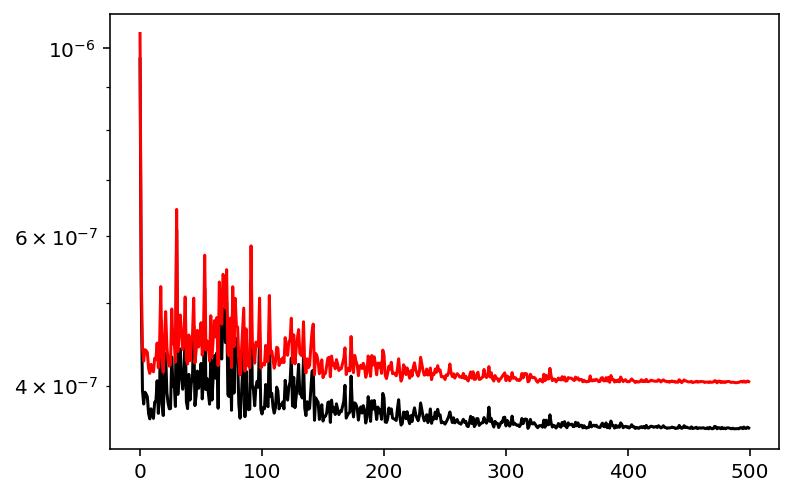

In [54]:
plt.yscale("log")
plt.plot(e_train, color="black")
plt.plot(e_test, color="red");

In [55]:
train_precidition = vmap(model3)(feature_train_)
train_error = jnp.mean(jnp.linalg.norm(targets_train - train_precidition, axis=2) / jnp.linalg.norm(targets_train, axis=2))

test_precidition = vmap(model3)(feature_test_)
test_error = jnp.mean(jnp.linalg.norm(targets_test - test_precidition, axis=2) / jnp.linalg.norm(targets_test, axis=2))

print("model", train_error, test_error)

for k in [1, 2, 3, 4]:
    a, b = get_errors(dataset, k)
    print(f"k = {k}", jnp.mean(a), jnp.mean(b))

model 4.174408522632504e-06 4.5194801102619235e-06
k = 1 7.728834575065744e-05 7.594985995076679e-05
k = 2 1.819986834480958e-05 1.7568258775564913e-05
k = 3 2.93989865433968e-06 2.82423474560407e-06
k = 4 1.2949527953535304e-06 1.2571931332157208e-06
